In [12]:
# %% IMPORTS
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pygimli           as pg
import pygimli.meshtools as mt
import cmasher           as cmr
import functools
import warnings

from pygimli.viewer             import pv
from pygimli.physics            import ert
from pygimli.physics.gravimetry import MagneticsModelling

warnings.filterwarnings("ignore")
%matplotlib qt


## Create ERT Data Container and Mesh

In [3]:
# Model dimensions
dx = 1
x = np.arange(0., 101, dx)
y = np.arange(0., 101, dx)
z = np.arange(-31, 0, dx)

In [4]:
# 2D SLM scheme
elecs = x[3:-3]
scheme = ert.createData(elecs=elecs,schemeName='slm')


# Add electrode coordinates of 3 lines
sensor_list = []
#  Line 1
for idx in np.arange(scheme.sensorCount()):
    sensor_list.append([elecs[idx],50,-0.3]) 
sensor_list=np.array(sensor_list)
scheme.setSensors(sensor_list)
print(scheme)

# Correct geometric factors for 3D
scheme["k"] = ert.geometricFactors(scheme, dim=3)

Data: Sensors: 95 data: 2162, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


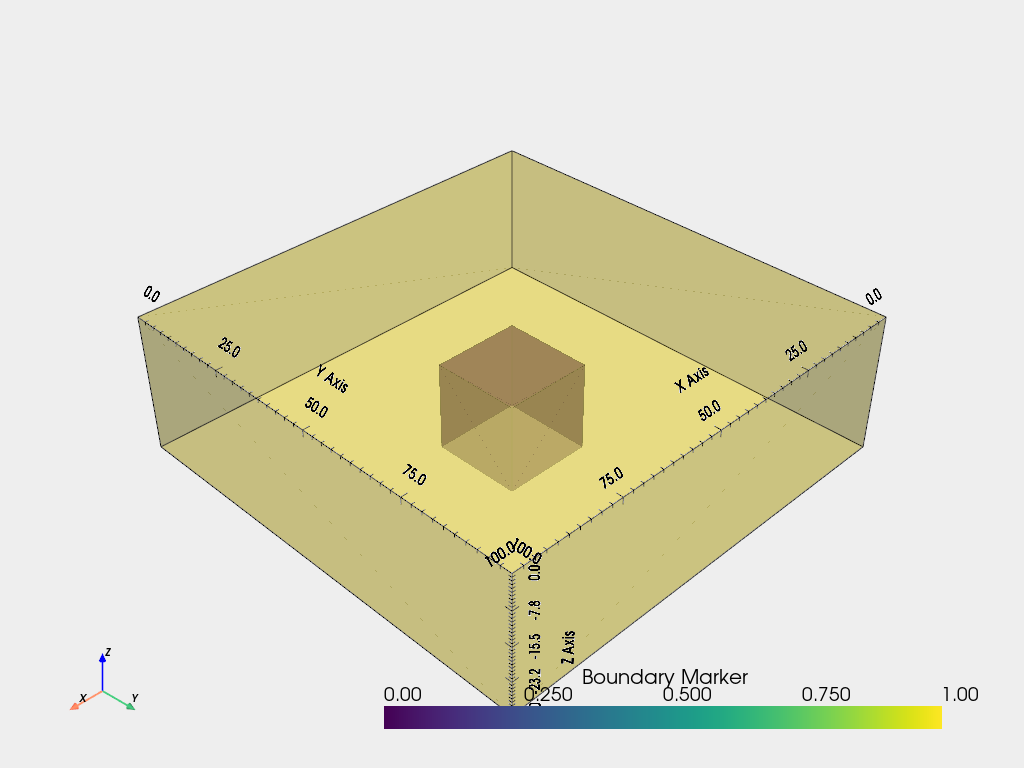

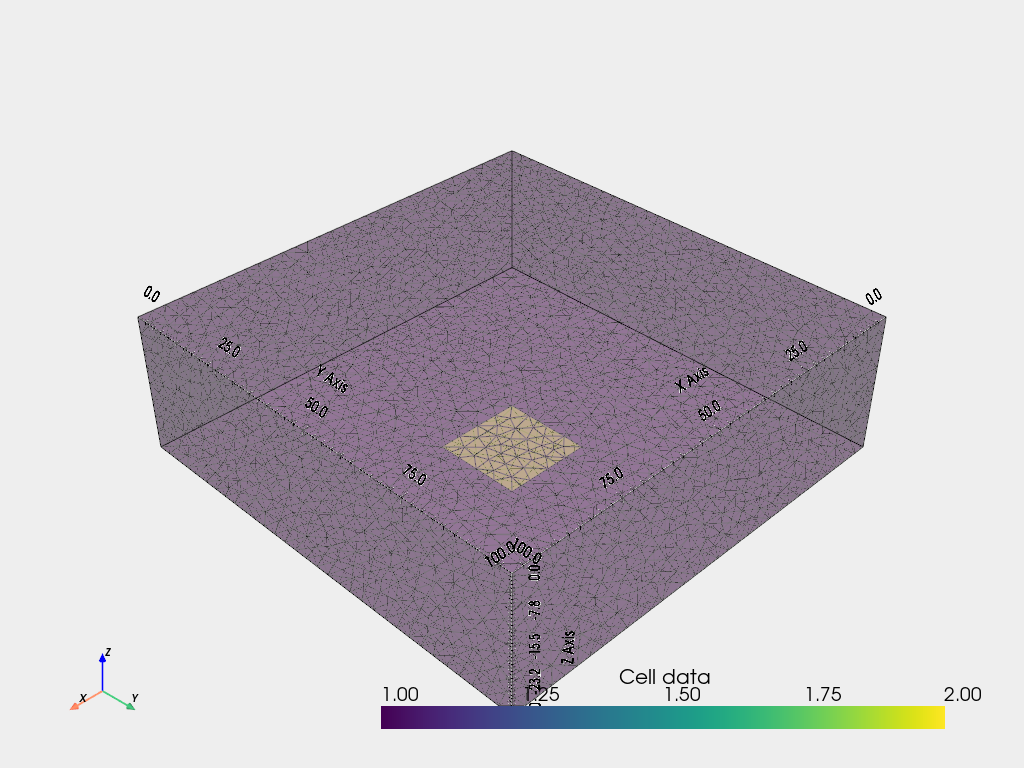

In [9]:
# Create mesh
plc = mt.createCube(size=[x.max(), y.max(), -z.min()],pos=[x.max()*0.5, y.max()*0.5, z.min()*0.5], boundaryMarker=1)

diatreme = mt.createCube(size=[20, 20, 20], pos=[x.max()*0.5, y.max()*0.5, z.min()+10], marker=2)
plc += diatreme


mesh = mt.createMesh(plc, area=10)
mesh["CM"]=np.array(mesh.cellMarkers())
mesh['CID']=np.array([c.id() for c in mesh.cells()])

sus = [0.1 if c==2 else 0 for c in mesh["CM"]] #susceptibility
mesh['sus'] = np.array(sus) #susceptibility 
res = [1000 if c==2 else 50 for c in mesh["CM"]] #resistivity
mesh['res'] = np.array(res) #resistivity

showModels=True
if showModels==True:
    pg.show(plc, showMesh=True,alpha=.30)
    pg.show(mesh, data=mesh['CM'], showMesh=True,alpha=.30)

## ERT Data Generation - This does not work

In [10]:
ert_data = ert.simulate(mesh, res=mesh['res'], scheme=scheme, verbose=True, seed=420)
ert.showData(ert_data)

RuntimeError: ./core/src/matrix.h:466		GIMLI::Vector<ValueType2>& GIMLI::Matrix<ValueType>::rowRef(GIMLI::Index) [with ValueType = double; GIMLI::Index = long long unsigned int]  94 <= 94

## Magnetics Data Generation - This works

In [14]:
F, I, D = 50000, 75, 25  # total field in nT
H = F * np.cos(np.deg2rad(I))
X = H * np.cos(np.deg2rad(D))
Y = H * np.sin(np.deg2rad(D))
Z = F * np.sin(np.deg2rad(I))
igrf = [D, I, H, X, Y, Z, F]

py, px = np.meshgrid(x[2:-2:4], y[2:-2:4])
px = px.ravel()
py = py.ravel()
points = np.column_stack((px, py, np.ones_like(px)*1))

# The forward operator
cmp = ["TFA"]  # ["Bx", "By", "Bz"]
fop = MagneticsModelling(mesh=mesh, points=points, cmp=cmp, igrf=igrf)
data = fop.response(mesh["sus"])


   0%|          |0/625 [00:00 < ?]

In [16]:
absError = np.abs(data) * 0.05 + 1
data += np.random.randn(len(data)) * absError

# Show data
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
ax.set_title('Simulated Data')
mm = np.max(np.abs(data))
im0 = ax.scatter(points[:,0], points[:,1], c=data, marker='8', cmap="PuOr", vmin=-mm, vmax=mm)
cb1 = fig.colorbar(im0, ax=ax, orientation='vertical')
cb1.ax.set_title('TFA\nnT')

Text(0.5, 1.0, 'TFA\nnT')